# Manning Publications: Data Science Bookcamp
## Case Study 3: Tracking Disease Outbreaks Using News Headlines¶
### Part 3: clustering headlines by location
                                                2020 Jamie Shaffer

### Objective

Cluster (find groups of) headlines based on the geographic coordinates using both KMeans clustering and DBSCAN. Visualize the clusters on a world map to check the results. Try different parameters and distance measures in the algorithms to produce better clusters.

### Workflow

1. Apply KMeans clustering and the DBSCAN algorithm to the latitude and longitude of each headline.
 - Use the default initial parameters for the algorithm or, if you have prior experience, choose parameters you think will work well.
 - Assign the cluster labels as another column on the DataFrame.
1. Visualize the clusters on a world map using the Basemap library. Color the headlines by the cluster assignment.
 - Determine if the clusters are reasonable: are headlines geographically close to one another in the same cluster?
 - Write a visualization function to quickly check clustering results.
1. In the likely case that the first clustering is not ideal, adjust the parameters of the algorithm you choose or use a different algorithm.
 - You can use an elbow plot to select the number of clusters in KMeans.
 - The two most important parameters for DBSCAN are eps and min_samples
1. Try using DBSCAN with the great circle distance, which finds the distance between two geographic points on a spherical globe.
 - Write a function to return the Great Circle distance between two coordinate points.
 - Use this function as the metric for DBSCAN
1. Repeat the above steps—cluster, visualize, analyze, tune—as many times as is required until the algorithm correctly assigns close points to the same cluster without too many outliers.

## IMPORTS

In [1]:
import re                         # 2.2.1
import numpy as np
import pandas as pd               # 0.25.0
import geonamescache              # 1.1.0
#import unidecode                  # has no __version__
from unidecode import unidecode

# PEP 484 type hints are easier with this
from typing import Tuple

from sklearn.cluster import DBSCAN

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

for library in [re,pd,geonamescache]:
    libname = (str(library)).split()[1]
    print(libname," version is ",library.__version__)

're'  version is  2.2.1
'pandas'  version is  0.25.0
'geonamescache'  version is  1.1.0


## GLOBALS

In [2]:
## GLOBALS

GLOBAL_FILL_STRING = 'not_specified'

# For debugging, set this to 1
debug = 0

# Headlines with cities are in this file:
fname1= r"C:\Users\jshaf\GitHub\data-science-portfolio\coursework"
fname2 = r"\manning-data-science-bookcamp\jupyter_notebooks\s2_headlines_lat_long_cc.csv"
fname = fname1 + fname2

# First step when using geonamescache
gc = geonamescache.GeonamesCache()  

# Note that the primary dataframe, df, will be used as a global, too

## FUNCTIONS

In [3]:
def plot_color_coded_map(lat_list, lon_list, \
                         colorplan='g', zoom_list=[-180,-90,180,90],\
                        ax=None)-> Basemap:
    '''Take in a latitude list, longitude list, color coding plan, and zoom_list, and plot a map
        INPUTS:
            lat_list : list of latitudes as floats
            lon_list : list of longitudues as floats
            colorplan: (optional) list of colors to use. Default: all green
            zoom_list: (optional) list of map corners allowing for zooming. Default: full earth
        OUTPUTS:
            map will be drawn
        RETURN:
            m        : map_plotter, in case you want to add something on top of the map
    '''
    fig = plt.figure(figsize=(12, 8))
    # Note that 'cyl' is the default projection
    if (ax == None):
        map_plotter = Basemap(projection='cyl',\
                             llcrnrlon = m_llcrnrlon,\
                             llcrnrlat = m_llcrnrlat,\
                             urcrnrlon = m_urcrnrlon,\
                             urcrnrlat = m_urcrnrlat )  
    else:
                map_plotter = Basemap(projection='cyl',\
                             llcrnrlon = m_llcrnrlon,\
                             llcrnrlat = m_llcrnrlat,\
                             urcrnrlon = m_urcrnrlon,\
                             urcrnrlat = m_urcrnrlat,\
                                     ax = ax)  

    map_plotter.drawcoastlines()
    map_plotter.shadedrelief()


    map_plotter.scatter(lon_list,lat_list,latlon=True, c=colorplan)
    
    return map_plotter

In [4]:
# https://stackoverflow.com/questions/17411940/matplotlib-scatter-plot-legend
# Handy way to build the legend
def get_legend_markers(D_label_color, marker="o", marker_kws={"linestyle":""}):
    """
    Usage: plt.legend(*legend_vars(D_taxon_color),
                      loc="lower center",
                      bbox_to_anchor=(0.5,-0.15),
                      fancybox=True, shadow=True,
                      prop={'size':15})

    Input: Dictionary object of {label:color}
    Output: Tuple of markers and labels
    """
    # Any marker you want to have in the legend must be put on the plot; this makes sure that it's on there.
    markers = [plt.Line2D([0,0],[0,0],color=color, marker=marker, **marker_kws) for color in D_label_color.values()]
    return (markers, D_label_color.keys())

In [5]:
def draw_cluster_map(df_in:pd.DataFrame,cluster_column:str,title:str,\
                    show_states=False, show_rivers=False,set_res='c'):
    '''Takes in a dataframe that has the columns latitude, longitude, DBSCAN_cluster and
       draws the clusters on a map
       INPUTS: 
           dataframe          pandas dataframe
           cluster_column     Name of the column containing the cluster integer
           title              Title to print on the map
           show_states        Draw the outlines of US states
           show_rivers        Draw rivers (useful for waterborne diseases)
           set_res            Set the resolution to c=crude, l=low, i=intermediate, h=high, f=full
           
        Back ported from development done in notebook s4* on 2020-03-27
    '''
    # setting up the zoom -- here's the whole world
    m_llcrnrlon = -180
    m_llcrnrlat = -90
    m_urcrnrlon = 180
    m_urcrnrlat = 90   
    
    # try calculating zoom
    if (1):
        border = 5.0
        m_llcrnrlat = df_in['latitude'].min() - border
        m_urcrnrlat = df_in['latitude'].max() + border
        m_llcrnrlon = df_in['longitude'].min() - border
        m_urcrnrlon = df_in['longitude'].max() + border
        
    # started with 'cyl'
    # try 'mill' for miller and add resolution
    
    map_plotter = Basemap(projection='cyl',\
                                 llcrnrlon = m_llcrnrlon,\
                                 llcrnrlat = m_llcrnrlat,\
                                 urcrnrlon = m_urcrnrlon,\
                                 urcrnrlat = m_urcrnrlat,\
                                 resolution=set_res)  
    
    cc1 = df_in[cluster_column].unique()
    cc2 = np.sort(cc1, axis=-1, kind='quicksort', order=None)
    cc2
    # Working out colors and legend match-up
    color_order =['blue', 'green', 'cyan', 'magenta',\
                  'yellow', 'black', 'purple', 'teal', 'pink', 'brown',\
                  'orange', 'red', 'coral', 'lightblue', 'lime', \
                  'lavender', 'turquoise', 'darkgreen', 'tan', 'salmon', \
                  'gold', 'plum', 'olive', 'burlywood', 'darkorange',\
                  'peru', 'tomato', 'saddlebrown', 'cadetblue', 'thistle',\
                  'forestgreen', 'darkkhaki', 'royalblue']
    

    D_label_color = {}
    plt.figure(figsize=(20, 20))
    map_plotter.drawcoastlines()
    map_plotter.drawcountries()
    map_plotter.shadedrelief()
    if (show_states):
        map_plotter.drawstates()
    if (show_rivers):
        map_plotter.drawrivers()
    spot_size=50

    for c in range(-1,len(cc2)-1):
        mini_df = df_in[df_in[cluster_column]==c]
        lat_list = mini_df['latitude']
        lon_list = mini_df['longitude']
        if (c == -1):  
            map_plotter.scatter(lon_list,lat_list,latlon=True, c='red', marker = 'x',s=spot_size)
            D_label_color["Isolate"] = 'red'
        else:
            map_plotter.scatter(lon_list,lat_list,latlon=True, c=color_order[c],s=spot_size)
            str_cluster = "Cluster " + str(c)
            D_label_color[str_cluster]=color_order[c]

    ax = plt.gca()    

    plt.title(title)
    ax.legend(*get_legend_markers(D_label_color),bbox_to_anchor=(0, 0, 1.09, 1)) 
    ##bbox_to_anchor=(0, 0, 1.09, 1)) -- puts it on the right
    ##bbox_to_anchor=(0, 0, .096, .32)) -- puts it in lower left, but may cover data
    return map_plotter

In [6]:
def great_circle_distance_metric(coord1:np.ndarray, coord2:np.ndarray, radius=3956)->float:
    '''DBSCAN will use a Euclidean metric by default, but others can be defined.
       I started this as a template function to teach me how to write a distance metric that DBSCAN will accept.
       I think that this function must conform to sklearn.metrics.pairwise_distances...and then the documentation is
       a little disappointing. I'm going to copy code from lesson 4. :\
       TODO: deep dive to understand how to build metrics for DBSCAN.
       INPUTS:
           coord1 a coordinate pair, e.g. lat long
           coord2 a coordinate pair       
       OUTPUT:
           return must be a single floating point number      
    '''
    # When I get back to refactor the code, consider other options and libraries
    #https://gis.stackexchange.com/questions/84885/difference-between-vincenty-and-great-circle-distance-calculations
    
    if np.array_equal(coord1, coord2):
        return 0.0

    # Convert lat/lon to radians
    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    # Find the difference between the coordinates
    delta_x, delta_y = coord2 - coord1
    
    # Apply Haversin formula
    haversin = np.sin(delta_x / 2) ** 2 + np.product(
        [np.cos(coord1[0]), np.cos(coord2[0]), np.sin(delta_y / 2) ** 2]
    )

    # Convert to distance in miles
    return 2 * radius * np.arcsin(haversin ** 0.5)

## MAIN

### Step 1: Revisit the raw data

In [7]:
df = pd.read_csv(fname)  # read the headlines with city/country information

In [8]:
df.head()

headline                  city  \
0  Pedro Juan Caballero Encounters Severe Symptom...  Pedro Juan Caballero   
1  Rumors about Hepatitis D Spreading in San Juan...   San Juan Capistrano   
2                 Zika Spreads to Palm Beach Gardens    Palm Beach Gardens   
3                 Zika Reported in North Miami Beach     North Miami Beach   
4     Zika cases in Vietnam's Ho Chi Minh City surge      Ho Chi Minh City   

   country  latitude  longitude  cityduplicates countrycode  
0      NaN -22.54722  -55.73333               1          PY  
1      NaN  33.50169 -117.66255               1          US  
2      NaN  26.82339  -80.13865               1          US  
3      NaN  25.93315  -80.16255               1          US  
4  Vietnam  10.82302  106.62965               1          VN

In [9]:

# setting up the zoom -- here's the whole world
m_llcrnrlon = -180
m_llcrnrlat = -90

m_urcrnrlon = 180
m_urcrnrlat = 90


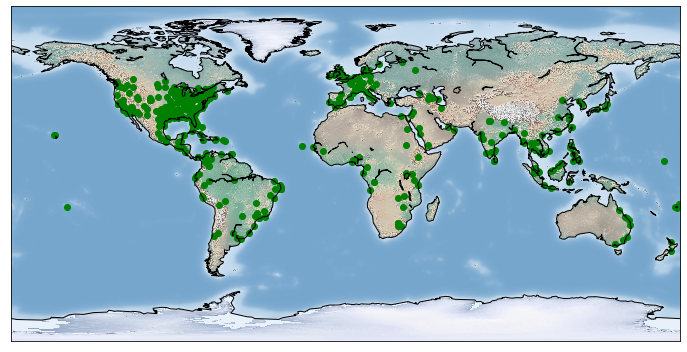

In [10]:
lat_list = list(df['latitude'])
lon_list = list(df['longitude'])
plot_color_coded_map(lat_list, lon_list)

In [11]:
colorplan = np.where(df["cityduplicates"]==1,'b','r')


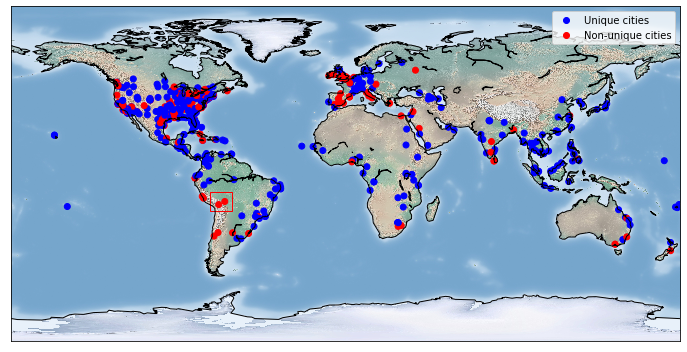

In [12]:
m = plot_color_coded_map(lat_list, lon_list, colorplan)

# Add a box around 
ax = plt.gca()  # get current axes
import matplotlib.patches as patches
rect = patches.Rectangle( (-73,-20), width=12, height=10, fill=False, color='r')
ax.add_patch(rect)

ax = plt.gca()
D_label_color = {"Unique cities":"blue", "Non-unique cities":"red"}
ax.legend(*get_legend_markers(D_label_color))

The clusters composed entirely of cities that had multiple possibilities should be watched closely -- note the
red box along the west coast of South America. It's possible that looking 
at the city names might put the actual cities in another existing cluster. This could make the difference 
between an "outbreak" and a "pandemic."

### Step 2: Try out KMeans clustering

In [13]:
from sklearn.cluster import KMeans

# create a list of lat, long pairs
lat_long_list = []

for i in df.iterrows():
    di = i[0]
    #print("di is {} and i is {} {}".format(di,type(di),di))
    #print("    lat {} and long {}".format(df.loc[di,'latitude'],df.loc[di,'longitude']))
    lat_long_list.append([df.loc[di,'latitude'],df.loc[di,'longitude']])
    
cluster_model = KMeans(n_clusters=2)   
cluster_list = cluster_model.fit_predict(lat_long_list)

In [14]:
df['Kcluster2'] = cluster_list

In [15]:
df.head()

headline                  city  \
0  Pedro Juan Caballero Encounters Severe Symptom...  Pedro Juan Caballero   
1  Rumors about Hepatitis D Spreading in San Juan...   San Juan Capistrano   
2                 Zika Spreads to Palm Beach Gardens    Palm Beach Gardens   
3                 Zika Reported in North Miami Beach     North Miami Beach   
4     Zika cases in Vietnam's Ho Chi Minh City surge      Ho Chi Minh City   

   country  latitude  longitude  cityduplicates countrycode  Kcluster2  
0      NaN -22.54722  -55.73333               1          PY          0  
1      NaN  33.50169 -117.66255               1          US          0  
2      NaN  26.82339  -80.13865               1          US          0  
3      NaN  25.93315  -80.16255               1          US          0  
4  Vietnam  10.82302  106.62965               1          VN          1

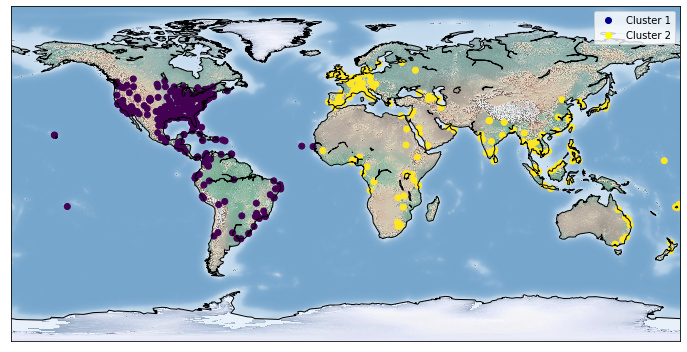

In [16]:
colorplan = list(df["Kcluster2"])

plot_color_coded_map(lat_list, lon_list, colorplan)

ax = plt.gca()
D_label_color = {"Cluster 1":"darkblue", "Cluster 2":"yellow"}
ax.legend(*get_legend_markers(D_label_color))

Clustering using KMeans with k=2 clearly has issues --> note the islands just off the west coast of Africa.

Let's search for a better k value.

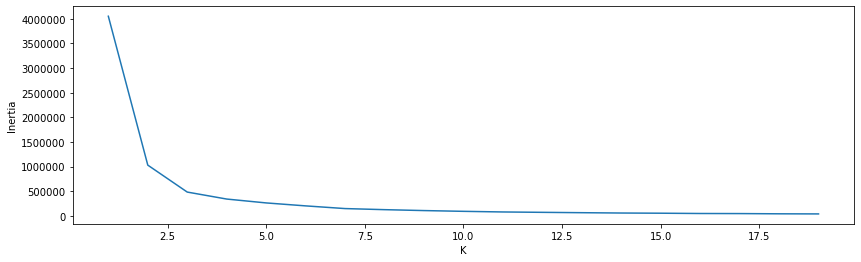

In [17]:
k_values = range(1, 20)
inertia_values = [KMeans(k).fit(lat_long_list).inertia_
                  for k in k_values]
plt.figure(figsize=(14, 4))
plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')

plt.show()

KMeans of about 3 or 4 seem to about all we need. Let's plot both and compare.

In [18]:
cluster_model = KMeans(n_clusters=3)   
cluster_list = cluster_model.fit_predict(lat_long_list)
df['Kcluster3'] = cluster_list
                                         
cluster_model = KMeans(n_clusters=4)   
cluster_list = cluster_model.fit_predict(lat_long_list)
df['Kcluster4'] = cluster_list                                        

Text(0.5, 1.0, 'KMeans for K = 4')

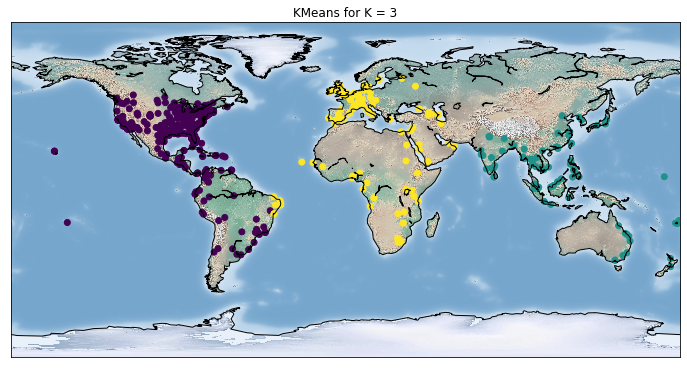

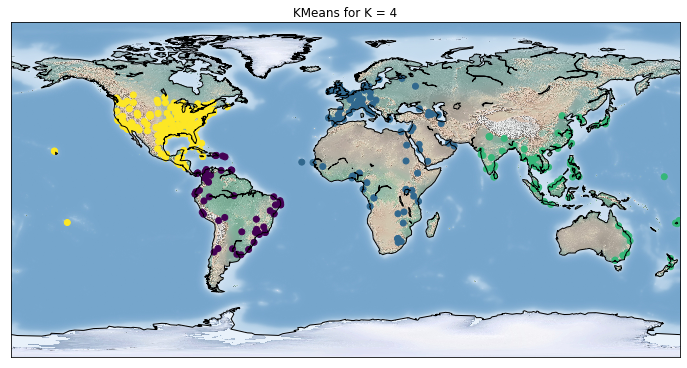

In [19]:
# TODO: get these plotted side by side -- make the subplots first and pass axes to make the map?
#fig, axes = plt.subplots(2, 1, figsize=(20, 10))

colorplan3 = list(df["Kcluster3"])
m1 = plot_color_coded_map(lat_list, lon_list, colorplan3) #, axes[0])
ax = plt.gca()
ax.set_title('KMeans for K = 3')

colorplan4 = list(df["Kcluster4"])
m2 = plot_color_coded_map(lat_list, lon_list, colorplan4) #, axes[1])
ax = plt.gca()
ax.set_title('KMeans for K = 4')

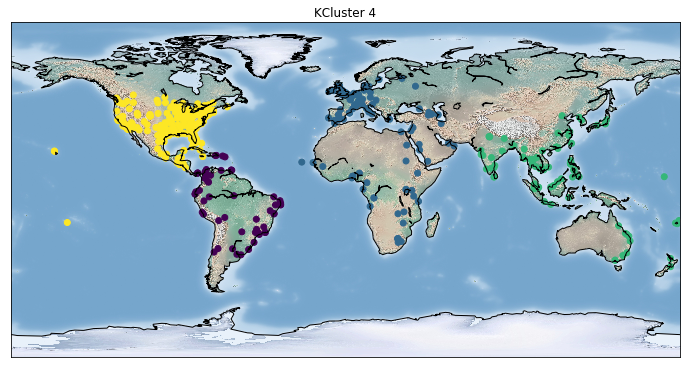

In [20]:
colorplan = list(df["Kcluster4"])
plot_color_coded_map(lat_list, lon_list, colorplan)

plt.title("KCluster 4")
plt.show()

### Step 3: Try out DBSCAN

In [21]:
# Values tried + results -- Euclidean distance metric
# e = 0.1, mp = 10   --> 1 cluster -- but it's all -1 which means "outside a cluster!"
# e = 1.0, mp = 10   --> 8 clusters
# e = 10,  mp = 10   --> 6 clusters, roughly the same as subcontinent regions
# e = 10,  mp =  5   --> 10 clusters
epsilon_e=10
min_points_e = 5

In [22]:
# Values tried + results -- Great Circle distance metric
# e = 10,  mp =  5   -->  5 clusters, all very small
# e = 20,  mp =  5   --> 11 clusters, all small
# e = 150, mp =  5   --> 17 clusters, US looks good, other areas have no clusters 
# e = 150, mp =  4   --> 20 clusters, medium, still not getting good clusters outside the US
# e = 180, mp =  4   --> 19 clusters, medium, still not getting good clusters outside the US, e.g. east coast Australia
# e = 300, mp =  5   --> 14 clusters, some are 1/2 the size of the US

# Error cases:
# e=250, m=4
#
# mp = 3 hits an error
epsilon_gc=150
min_points_gc = 5

Without doing a deep dive into distance metrics, these results seem to indicate that
 - Euclidean distance works best for most of the world
 - Great Circle distance works best for grouping regions of the US

Therefore, both metrics will be calculated so that both options are available in the next step.

In [23]:

cluster_model_e = DBSCAN(eps=epsilon_e, min_samples=min_points_e) # uses default Euclidean - might tunnel through earth
cluster_model_gc = DBSCAN(eps=epsilon_gc, min_samples=min_points_gc,metric=great_circle_distance_metric)
headline_clusters_e = cluster_model_e.fit_predict(lat_long_list)
headline_clusters_gc = cluster_model_gc.fit_predict(lat_long_list)

In [24]:
df['DBSCAN_cluster_e'] = headline_clusters_e
df['DBSCAN_cluster_e'].nunique()

10

In [25]:
df['DBSCAN_cluster_gc'] = headline_clusters_gc
df['DBSCAN_cluster_gc'].nunique()

17

In [26]:
cc1 = df['DBSCAN_cluster_e'].unique()
cc2 = np.sort(cc1, axis=-1, kind='quicksort', order=None)
cc2

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8], dtype=int64)

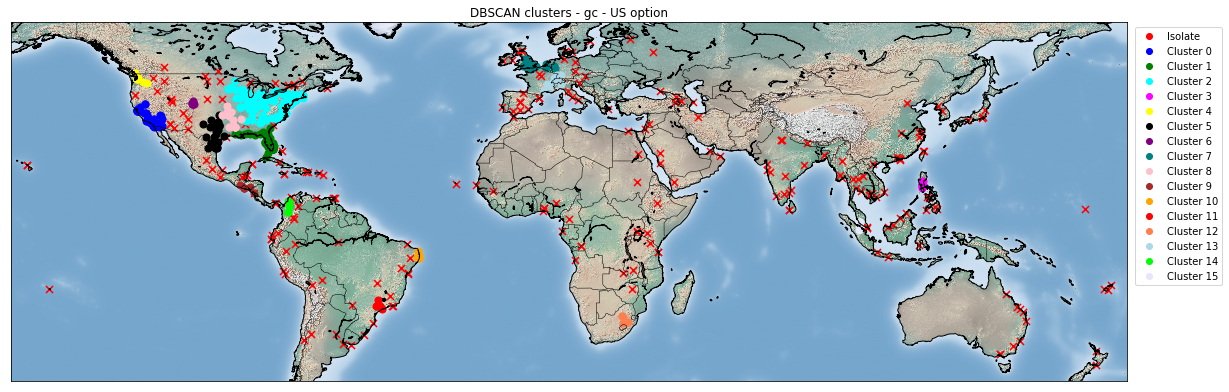

In [27]:
m = draw_cluster_map(df,'DBSCAN_cluster_gc','DBSCAN clusters - gc - US option',False,False,'l')

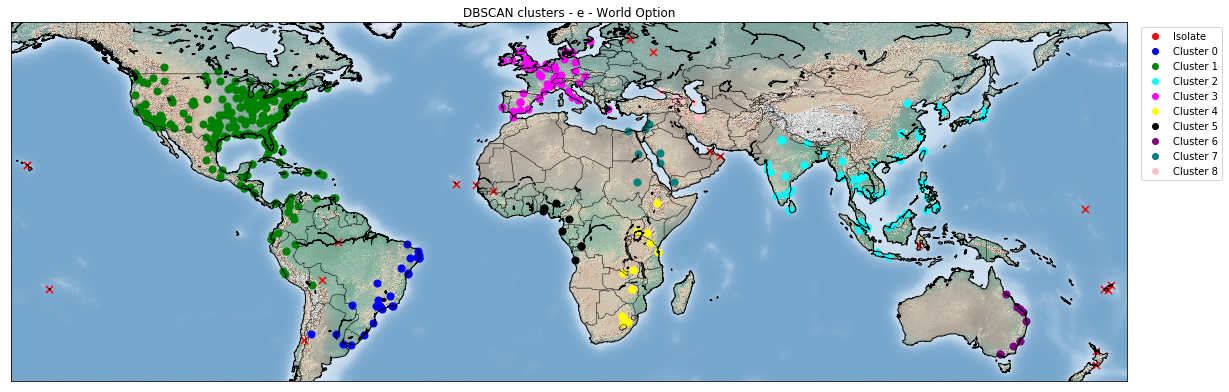

In [28]:
m = draw_cluster_map(df,'DBSCAN_cluster_e','DBSCAN clusters - e - World Option',False,False,'l')

In [29]:
df.head()

headline                  city  \
0  Pedro Juan Caballero Encounters Severe Symptom...  Pedro Juan Caballero   
1  Rumors about Hepatitis D Spreading in San Juan...   San Juan Capistrano   
2                 Zika Spreads to Palm Beach Gardens    Palm Beach Gardens   
3                 Zika Reported in North Miami Beach     North Miami Beach   
4     Zika cases in Vietnam's Ho Chi Minh City surge      Ho Chi Minh City   

   country  latitude  longitude  cityduplicates countrycode  Kcluster2  \
0      NaN -22.54722  -55.73333               1          PY          0   
1      NaN  33.50169 -117.66255               1          US          0   
2      NaN  26.82339  -80.13865               1          US          0   
3      NaN  25.93315  -80.16255               1          US          0   
4  Vietnam  10.82302  106.62965               1          VN          1   

   Kcluster3  Kcluster4  DBSCAN_cluster_e  DBSCAN_cluster_gc  
0          0          0                 0                 -1  
1          0          3                 1                  0  
2          0          3                 1                  1  
3          0          3                 1                  1  
4          1          2                 2                 -1

In [30]:
df.drop(['Kcluster2','Kcluster3','Kcluster4'],axis=1,inplace=True)
df.head()

headline                  city  \
0  Pedro Juan Caballero Encounters Severe Symptom...  Pedro Juan Caballero   
1  Rumors about Hepatitis D Spreading in San Juan...   San Juan Capistrano   
2                 Zika Spreads to Palm Beach Gardens    Palm Beach Gardens   
3                 Zika Reported in North Miami Beach     North Miami Beach   
4     Zika cases in Vietnam's Ho Chi Minh City surge      Ho Chi Minh City   

   country  latitude  longitude  cityduplicates countrycode  DBSCAN_cluster_e  \
0      NaN -22.54722  -55.73333               1          PY                 0   
1      NaN  33.50169 -117.66255               1          US                 1   
2      NaN  26.82339  -80.13865               1          US                 1   
3      NaN  25.93315  -80.16255               1          US                 1   
4  Vietnam  10.82302  106.62965               1          VN                 2   

   DBSCAN_cluster_gc  
0                 -1  
1                  0  
2                  1  
3                  1  
4                 -1

In [31]:
# Updated to avoid over-writing previous output that used Euclidean distances
# Conclusion as of 2020-03-27 is that
# DBSCAN_clusters_e -- better for world
# DBSCAN_clusters_gc -- better for US
df.to_csv('s3_headline_clusters_gc.csv')